<a href="https://colab.research.google.com/github/hy-23/CMake/blob/master/Line_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

from google.colab import drive
drive.mount('/content/drive/')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
2.8.0


In [2]:
column_names = ['y', 'x']
raw_dataset = pd.read_csv('/content/drive/MyDrive/ResourceFiles/LineEquation.csv', names=column_names,
                          na_values='?', comment='\t',
                          sep=';', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
dataset.isna().sum()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print('Shape of entire data set is {}'.format(dataset.shape))
print('Shape of training set is {}'.format(train_dataset.shape))
print('Shape of test set is {}'.format(test_dataset.shape))

Shape of entire data set is (1148, 2)
Shape of training set is (918, 2)
Shape of test set is (230, 2)


In [4]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('x')
test_labels = test_features.pop('x')

In [5]:
print('Shape of train_features is {}'.format(train_features.shape))
print('Shape of test_features is {}'.format(test_features.shape))
print()
print('Shape of train_labels is {}'.format(train_labels.shape))
print('Shape of test_labels is {}'.format(test_labels.shape))

Shape of train_features is (918, 1)
Shape of test_features is (230, 1)

Shape of train_labels is (918,)
Shape of test_labels is (230,)


# Normalizer

In [6]:
print('Shape of train_features is {}'.format(train_features.shape))
y_values = np.array(train_features['y'])
print('Shape of y_values is {}'.format(y_values.shape))

Shape of train_features is (918, 1)
Shape of y_values is (918,)


In [7]:
normalizer = tf.keras.layers.Normalization(input_shape=[1, ], axis=None)
normalizer.adapt(y_values)

print('Mean value of y_values is {}'.format(normalizer.mean.numpy()))

Mean value of y_values is [497.852]


In [8]:
model = tf.keras.Sequential([
                             normalizer,
                             tf.keras.layers.Dense(units=1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [9]:
%%time

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

CPU times: user 17.8 ms, sys: 3.71 ms, total: 21.5 ms
Wall time: 52.8 ms


In [10]:
history = model.fit(
    train_features['y'],
    train_labels,
    epochs=400,
    # initially, 1000 was chosen, but from the learning_curve it was found that 400 is enough.
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
395,96.539680,94.595154,395
396,94.225975,92.310989,396
397,91.926208,90.021622,397
398,89.632462,87.741013,398
399,87.319389,85.454079,399


In [12]:
x = tf.linspace(0, 1000, 1001)
pred = model.predict(x)

In [13]:
def plot(x, y):
  plt.scatter(train_features['y'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('y')
  plt.ylabel('x')
  plt.legend()

In [14]:
def learning_curve(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)

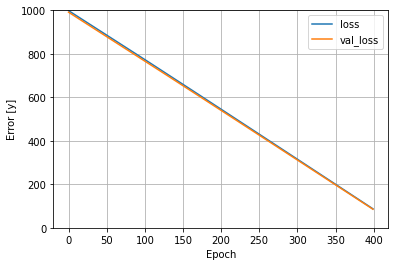

In [15]:
learning_curve(history)